In [ ]:
! pip install -q optax equinox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import jax.numpy as jnp
import equinox as eqx
import optax
import time

from jax import config, random, vmap
from jax.tree_util import tree_map, tree_flatten
from jax.lax import dot_general, scan
from jax.nn import gelu

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

# Deep Operator Network

Deep Operator Network (DeepONet) was proposed in https://arxiv.org/abs/1910.03193 based on Universal Approximation Theorem for Operators https://ieeexplore.ieee.org/document/392253.

The architecture prescribe only general parametric form with flexible components. Given that it is not entirely clear what is DeepONet. Here we consider a basic version with MLPs.

DeepONet consists of two parts: branch network and trunk network.

Branch network process functional PDE parameters, e.g., diffusion coefficient, evaluated on a fixed discrete grid. In case of MLP branch network reads

\begin{equation}
  \begin{split}
    &b^{(0)} = a(x_{D}),\\
    &b^{(n)} = \text{gelu}\left(A^{(n)}b^{(n-1)} + a^{(n)}\right),\,1\leq n< N,\\
    &b^{(N)} = A^{(N)}b^{(N-1)} + a^{(N)}.
  \end{split}
\end{equation}

Trunk network is the one that provides basis functions. It is again MLP of similar form that the ones applied in physics-informed neural networks https://arxiv.org/abs/2308.08468 and implicit neural representation https://arxiv.org/abs/2006.09661, https://arxiv.org/abs/2003.08934. We use Siren https://arxiv.org/abs/2006.09661 that reads:

\begin{equation}
  \begin{split}
    &t^{(0)} = x,\\
    &t^{(n)} = \sin\left(A^{(n)}t^{(n-1)} + a^{(n)}\right),\,1\leq n< N,\\
    &t^{(N)} = A^{(N)}t^{(N-1)} + a^{(N)}.
  \end{split}
\end{equation}

Given that two networks the final form of DeepONet is

\begin{equation}
  F[a(x)] = \sum_{i} t_{i}(x) b_{i}[a(x_{D})] + \beta.
\end{equation}

So one can see that the role of trunk network is to provide basis for all solutions of parametric PDE, and the role of branch network is to learn the mapping from

In [ ]:
def normalize_conv_siren(A, key):
    A = eqx.tree_at(lambda x: x.weight, A, random.uniform(key, A.weight.shape, minval=-1, maxval=1)*jnp.sqrt(6/A.weight.shape[1]))
    A = eqx.tree_at(lambda x: x.bias, A, jnp.zeros_like(A.bias))
    return A

class Siren(eqx.Module):
    convs: list
    def __init__(self, N_features, key, D=1, s0=30):
        keys = random.split(key, len(N_features)-1)
        self.convs = [eqx.nn.Conv(D, n_in, n_out, 1, key=key) for i, (n_out, n_in, key) in enumerate(zip(N_features[1:], N_features[:-1], keys))]
        self.convs = [normalize_conv_siren(c, key) for c, key in zip(self.convs, keys)]
        self.convs[0] = eqx.tree_at(lambda x: x.weight, self.convs[0], self.convs[0].weight*s0)

    def __call__(self, t):
        t = self.convs[0](t)
        for c in self.convs[1:]:
            t = jnp.sin(t)
            t = c(t)
        return t

class MLP(eqx.Module):
    weights: list
    biases: list

    def __init__(self, N_features, key):
        keys = random.split(key, len(N_features)-1)
        self.weights = [random.normal(key, (n_out, n_in)) * jnp.sqrt(2/n_in) for key, n_out, n_in in zip(keys, N_features[1:], N_features[:-1])]
        self.biases = [jnp.zeros((n_out, )) for n_out, n_in in zip(N_features[1:], N_features[:-1])]

    def __call__(self, t):
        t = self.weights[0] @ t + self.biases[0]
        for w, b in zip(self.weights[1:], self.biases[1:]):
            t = gelu(t)
            t = w @ t + b
        return t

class DeepONet(eqx.Module):
    trunk: eqx.Module
    branch: eqx.Module
    bias: jnp.array

    def __init__(self, N_features_trunk, N_features_branch, key, D=1):
        keys = random.split(key)
        self.branch = MLP(N_features_branch, keys[0])
        self.trunk = Siren(N_features_trunk, keys[1], D=D)
        self.bias = jnp.array([0.0,])

    def __call__(self, u, x):
        w = self.branch(u)
        v = self.trunk(x)
        return jnp.sum(w.reshape([-1,] + [1,]*(v.ndim-1))*v, 0) + self.bias

def compute_loss(model, features, coordinates, targets):
    prediction = vmap(model, in_axes=(0, None))(features, coordinates)
    mean_error = jnp.mean(jnp.linalg.norm((prediction - targets).reshape(prediction.shape[0], -1), axis=1))
    return mean_error

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

def make_step(carry, n, optim):
    model, features, coordinates, targets, opt_state = carry
    loss, grads = compute_loss_and_grads(model, features[n], coordinates, targets[n])
    grads = tree_map(lambda x: x.conj(), grads)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return [model, features, coordinates, targets, opt_state], loss

def compute_relative_error(model, features, targets, n):
    prediction = vmap(model, in_axes=(0, None))(features[n], coordinates)
    relative_error = jnp.linalg.norm((prediction - targets[n]).reshape(n.size, -1), axis=1) / jnp.linalg.norm(targets[n].reshape(n.size, -1), axis=1)
    return relative_error

# KdV D=1

In [ ]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_1D(key=random.PRNGKey(11), N_samples=1000, c_min = 500, c_max = 900, delta_t = 0.3*1/700, N_x=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t1 = t0 + delta_t
    features = vmap(s, in_axes=(None, 0, 0))(x, t0, c)
    targets = vmap(s, in_axes=(None, 0, 0))(x, t1, c)
    features = jnp.expand_dims(features, 1)
    targets = jnp.expand_dims(targets, 1)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, jnp.expand_dims(x, 0)

dataset generation time: 2.00277 s
Shapes of features, targets and coordinates: (1000, 100) (1000, 100) (1, 100)
model size: 15351
training time: 18.71493 s
train error 0.03847604990005493, test error 0.04396260157227516


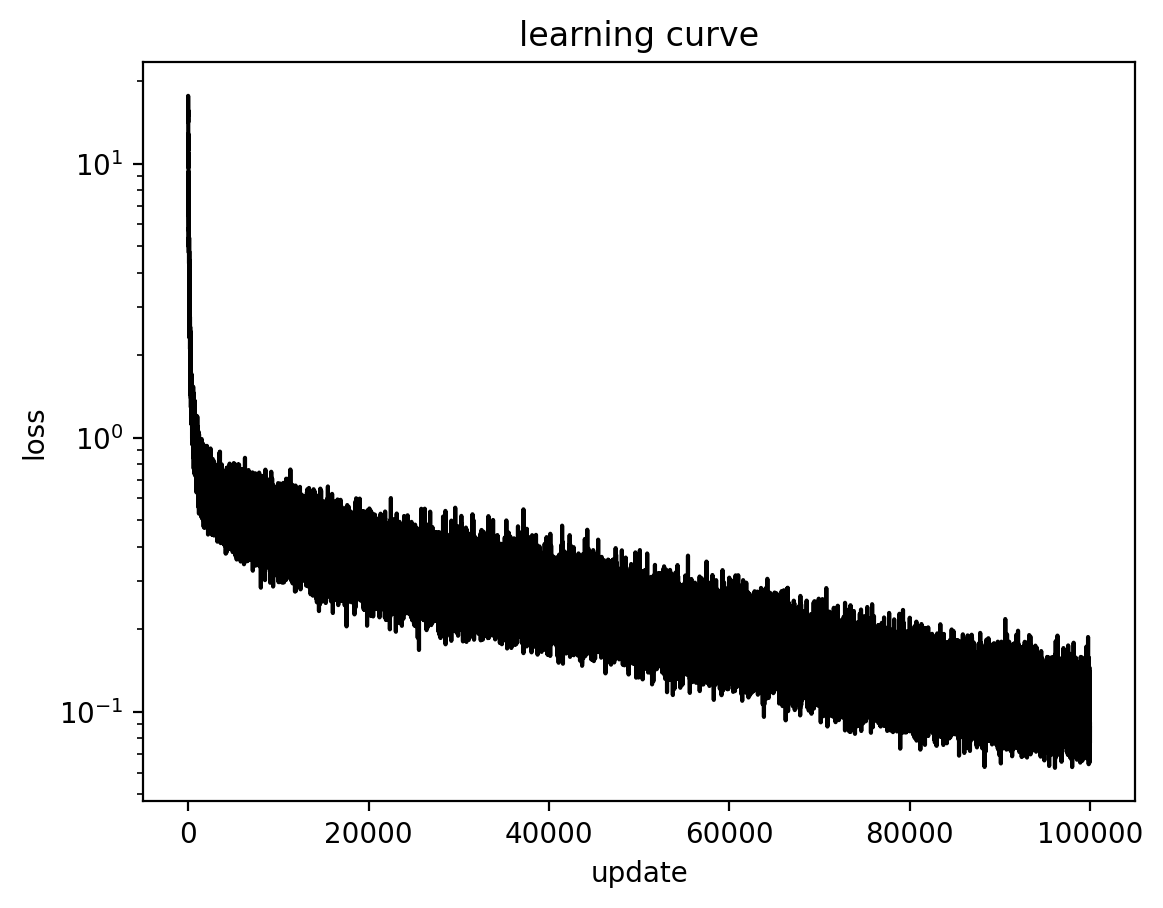

In [ ]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_1D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

features = features[:, 0]
targets = targets[:, 0]

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_features_trunk = [coordinates.shape[0], 50, 50, 50]
N_features_barnch = [features.shape[1], 50, 50, 50]
key = random.PRNGKey(11)
model = DeepONet(N_features_trunk, N_features_barnch, key)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 1e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 100000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# Elliptic D=1

In [ ]:
def get_coordinates(N):
    x = jnp.linspace(0, 1, N+2)[1:]
    h = x[1] - x[0]
    x_half = x - h/2
    return x_half, x[:-1]

def get_matrix(sigma_half):
    A = jnp.diag(sigma_half[:-1] + sigma_half[1:]) - jnp.diag(sigma_half[1:-1], k=-1) - jnp.diag(sigma_half[1:-1], k=1)
    return A

def get_matrices(x, N, p, l):
    return jnp.stack([jnp.exp(1j*x*2*jnp.pi*k) / (1 + (2*jnp.pi*k / l)**2)**p for k in range(N)], 1)

def get_diffusion_coefficient(key, M, s):
    coeff = random.normal(key, (M.shape[1],), dtype=jnp.complex64)
    sigma = jnp.real(M @ coeff)
    sigma = s*(sigma - jnp.min(sigma)) / (jnp.max(sigma) - jnp.min(sigma)) + 1
    return sigma

def piecewise_linear_diffusion_coefficient(key, x, s, k):
    keys = random.split(key)
    vals = random.uniform(keys[0], (k,), minval=1, maxval=s)
    coords = random.uniform(keys[1], (k,))
    coords = coords.at[0].set(0)
    coords = coords.at[-1].set(1)
    return jnp.interp(x, coords, vals)

def get_data(key, N_samples, constant_rhs=False, laplace=False, N = 100, s=4):
    M = 150
    p = 2
    l = 10
    k = 5
    x_half, x = get_coordinates(N)
    h = x[1] - x[0]
    T = get_matrices(x_half, M, p, l)
    T_x = get_matrices(x, M, p, l)
    keys = random.split(key, N_samples)

    features = []
    targets = []
    Matrices = []
    for key in keys:
        key1, key2 = random.split(key)
        if laplace:
            sigma = jnp.ones_like(x_half)
        else:
            sigma = get_diffusion_coefficient(key1, T, s)
        A = get_matrix(sigma)

        if constant_rhs:
            b = jnp.ones((N,))
        else:
            coeff = random.normal(key2, (T_x.shape[1],), dtype=jnp.complex64)
            b = jnp.real(T_x @ coeff)
        b = h**2 * b
        sol = jnp.linalg.solve(A, b)
        sigma = get_diffusion_coefficient(key1, T_x, s)
        if laplace:
            sigma = jnp.ones_like(x)
        features.append(jnp.stack([sigma, b/h**2]))
        targets.append(sol)
    features = jnp.stack(features, 0)
    targets = jnp.expand_dims(jnp.stack(targets, 0), 1)
    return features, targets, jnp.expand_dims(x, 0)

def get_dataset_elliptic_1D(name, N_samples=1000, key=random.PRNGKey(33), N=100, s=4, normalize=False):
    if name == "Dataset 1":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=False, N=N, s=s)
    elif name == "Dataset 2":
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=True, laplace=False, N=N, s=s)
    else:
        features, targets, coordinates = get_data(key, N_samples, constant_rhs=False, laplace=True, N=N, s=s)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale
    return features, targets, coordinates

dataset generation time: 10.72906 s
Shapes of features, targets and coordinates: (1000, 200) (1000, 100) (1, 100)
model size: 20351
training time: 17.3602 s
train error 0.02303059585392475, test error 0.030312975868582726


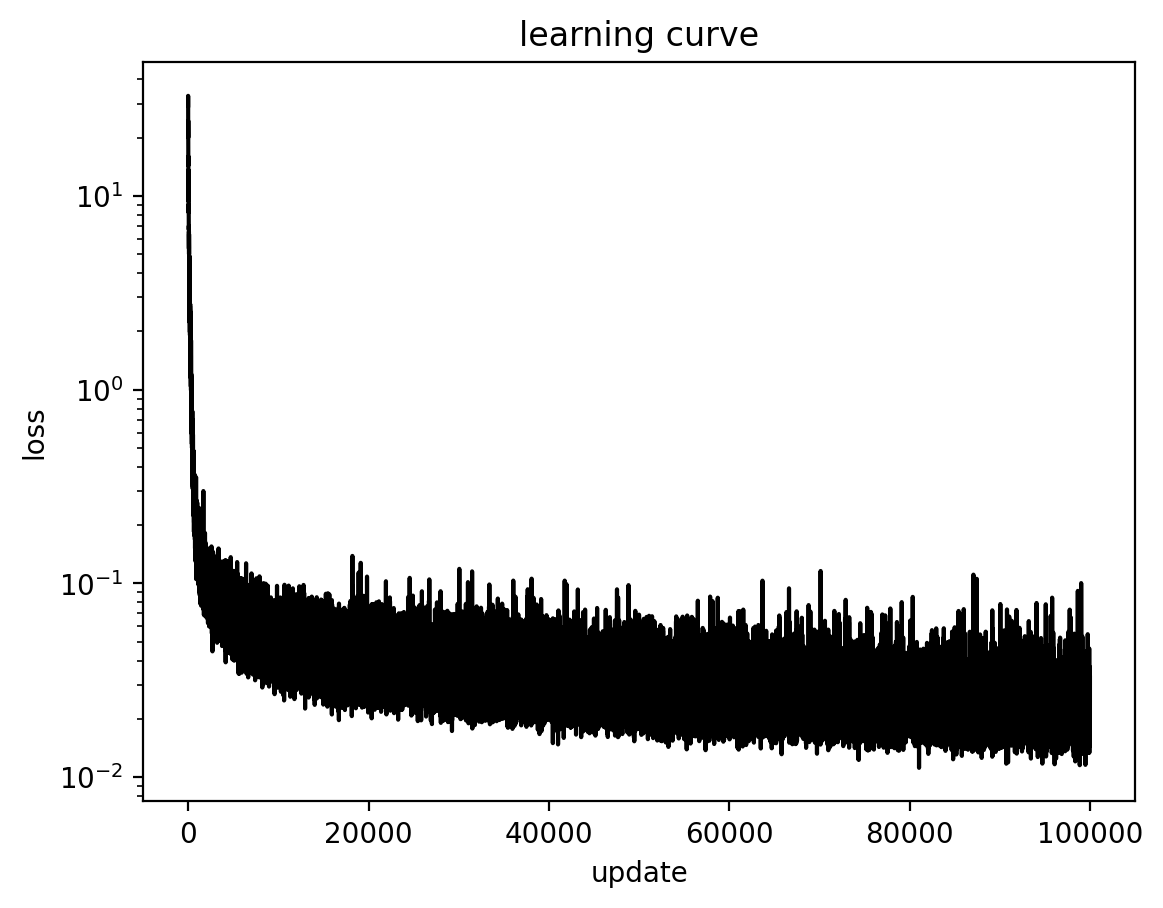

In [ ]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_elliptic_1D('Dataset 1', N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

features = features.reshape(N_samples, -1)
targets = targets[:, 0]

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_features_trunk = [coordinates.shape[0], 50, 50, 50]
N_features_barnch = [features.shape[1], 50, 50, 50]
key = random.PRNGKey(11)
model = DeepONet(N_features_trunk, N_features_barnch, key)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 1e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 100000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

# KdV D=2

In [ ]:
def s(x, t, c):
    return c/jnp.cosh(jnp.sqrt(c)*((x-c*t)%1.0-0.5)/2)**2/2

def get_dataset_KdV_2D(key=random.PRNGKey(11), N_samples=1000, c_min=500, c_max=900, delta_t=0.3*1/700, N_x=100, N_t=100, normalize=False):
    x = jnp.linspace(0, 1, N_x)
    keys = random.split(key)
    c = c_min + (c_max - c_min) * random.uniform(keys[0], (N_samples,))
    x0 = random.uniform(keys[1], (N_samples,))
    t0 = x0 / c
    t = delta_t * jnp.linspace(0, 1, N_t)
    X, T = jnp.meshgrid(x, t)
    coordinates = jnp.stack([X, T], 0)
    t = jnp.expand_dims(t, 0) + jnp.expand_dims(t0, 1)
    t = jnp.expand_dims(t, 2)
    x = jnp.expand_dims(x, 0)
    solutions = vmap(s, in_axes=(None, 0, 0))(x, t, c) # solutions.shape = (N_samples, N_t, N_x)

    features = solutions[:, :1, :]
    targets = jnp.expand_dims(solutions, 1)

    if normalize:
        features_scale = jnp.max(jnp.abs(features), axis=[0, 2], keepdims=True)
        targets_scale = jnp.max(jnp.abs(targets), axis=[0, 2, 3], keepdims=True)
        features = features / features_scale
        targets = targets / targets_scale

    return features, targets, coordinates

trial 1

dataset generation time: 1.00281 s
Shapes of features, targets and coordinates: (1000, 100) (1000, 100, 100) (2, 100, 100)
model size: 15401
training time: 131.28273 s
train error 0.22765883803367615, test error 0.23348815739154816


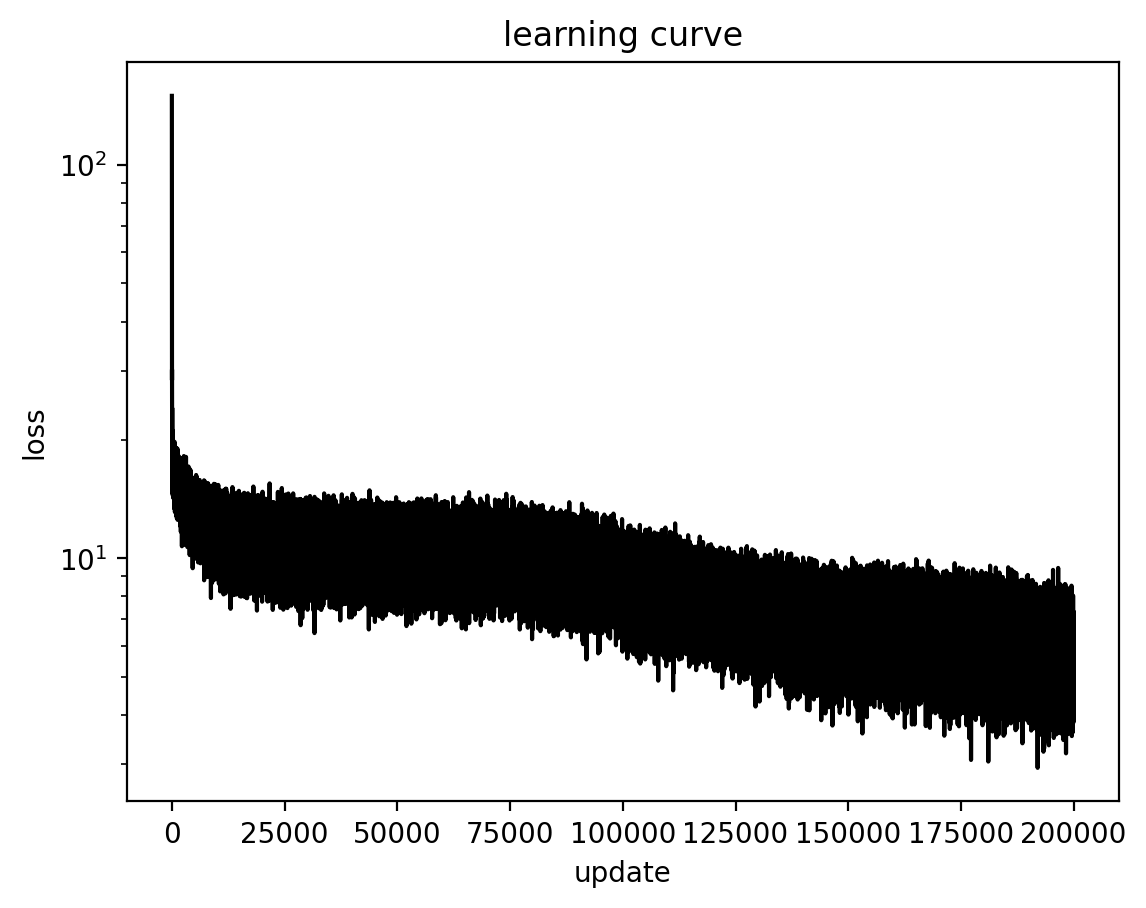

In [ ]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_2D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

features = features[:, 0]
targets = targets[:, 0]

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_features_trunk = [coordinates.shape[0], 50, 50, 50]
N_features_branch = [features.shape[1], 50, 50, 50]
key = random.PRNGKey(11)
model = DeepONet(N_features_trunk, N_features_branch, key, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 5e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 10
N_run = 200000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

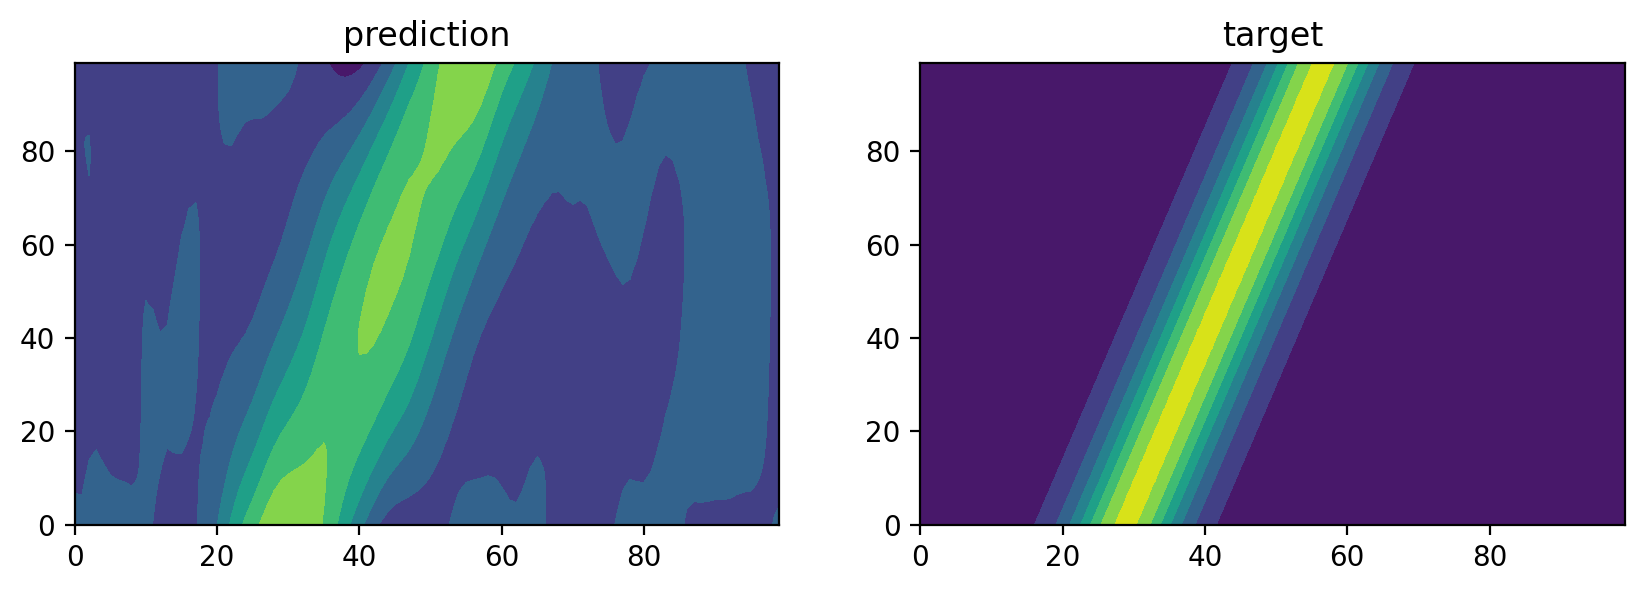

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sample = 5
ax[0].set_title("prediction")
ax[1].set_title("target")
ax[0].contourf(model(features[sample], coordinates))
ax[1].contourf(targets[sample]);

trial 2

dataset generation time: 0.01367 s
Shapes of features, targets and coordinates: (1000, 100) (1000, 100, 100) (2, 100, 100)
model size: 8701
training time: 269.52739 s
train error 0.123647041618824, test error 0.12729941308498383


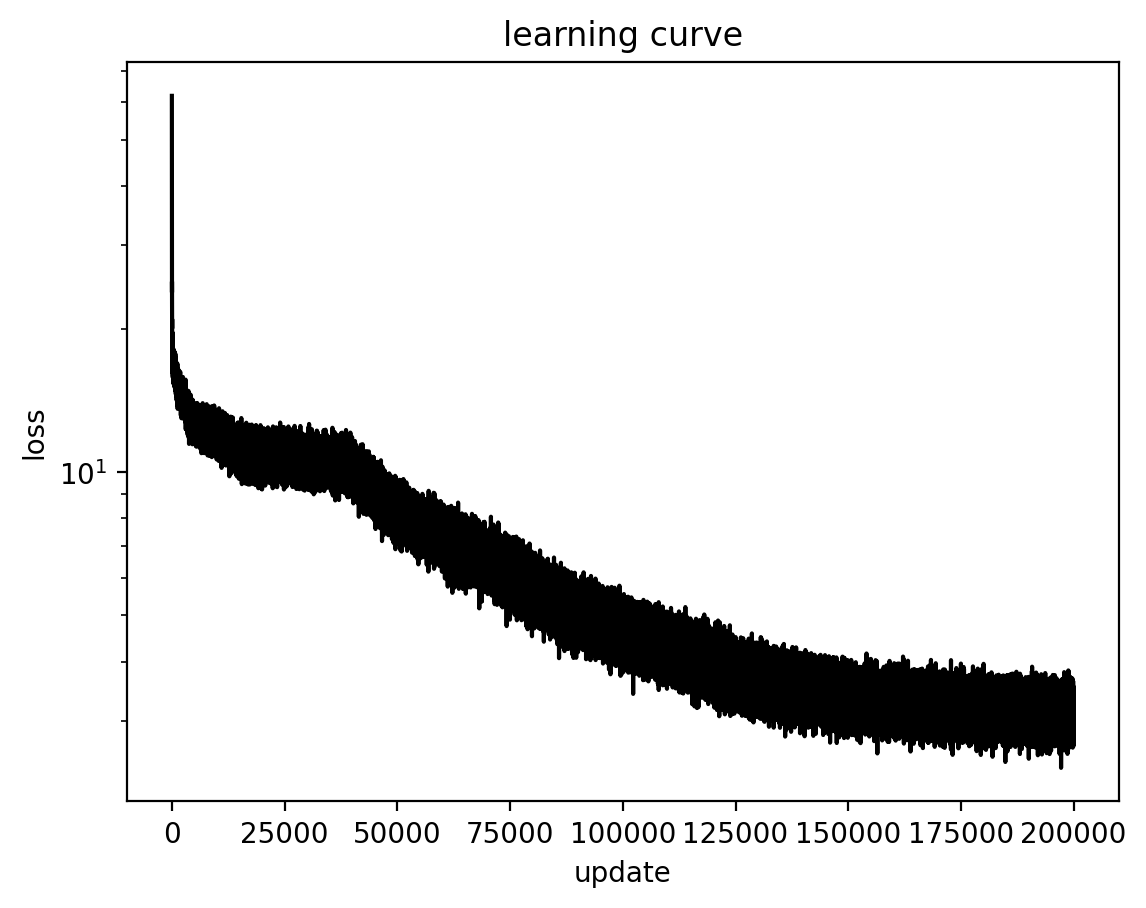

In [ ]:
# generate dataset
N_samples = 1000
key = random.PRNGKey(11)
start = time.time()
features, targets, coordinates = get_dataset_KdV_2D(key=key, N_samples=N_samples, normalize=True)
stop = time.time()
print("dataset generation time:", round(stop - start, ndigits=5), "s")

features = features[:, 0]
targets = targets[:, 0]

print("Shapes of features, targets and coordinates:", features.shape, targets.shape, coordinates.shape)

# define model
N_features_trunk = [coordinates.shape[0], 30, 30, 30, 30]
N_features_branch = [features.shape[1], 30, 30, 30, 30]
key = random.PRNGKey(11)
model = DeepONet(N_features_trunk, N_features_branch, key, D=2)
model_size = sum(tree_map(jnp.size, tree_flatten(model)[0], is_leaf=eqx.is_array))
print("model size:", model_size)

# define optimizer
learning_rate = 5e-4
optim = optax.lion(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

# specify training loop parameters
N_batch = 50
N_run = 200000
N_train = 800
key = random.PRNGKey(11)
ind = random.choice(key, N_train, (N_run, N_batch))
make_step_scan = lambda a, b: make_step(a, b, optim)
carry = [model, features, coordinates, targets, opt_state]

# training
start = time.time()
carry, history = scan(make_step_scan, carry, ind)
stop = time.time()
model = carry[0]
print("training time:", round(stop - start, ndigits=5), "s")

# evaluation
ind = jnp.arange(features.shape[0]).reshape(-1, N_batch)
compute_error = lambda a, x: (None, compute_relative_error(model, features, targets, x))
_, errors = scan(compute_error, None, ind)
errors = errors.reshape(-1,)
train_error = errors[:N_train]
test_error = errors[N_train:]

print(f"train error {jnp.mean(train_error)}, test error {jnp.mean(test_error)}")

plt.yscale("log")
plt.plot(history, color="black")
plt.title("learning curve")
plt.ylabel("loss")
plt.xlabel("update");

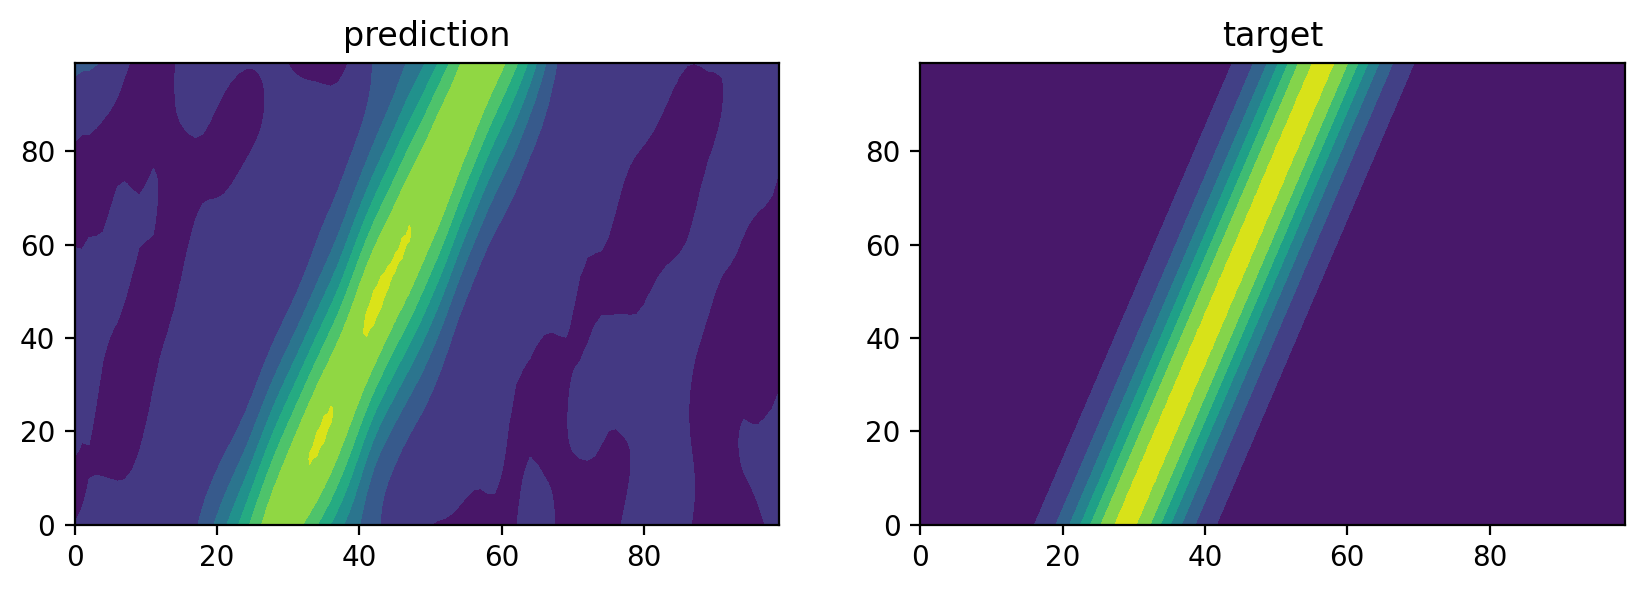

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sample = 5
ax[0].set_title("prediction")
ax[1].set_title("target")
ax[0].contourf(model(features[sample], coordinates))
ax[1].contourf(targets[sample]);